In [1]:
import time
import cv2
import polanalyser as pa
from PIL import Image
import matplotlib.pyplot as plt
from mpldatacursor import datacursor
import numpy as np
import os
import sys
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
from scipy import ndimage
import glob

%matplotlib notebook
import importlib
pyfilepath = '..//controller.py'
dirname, basename = os.path.split(pyfilepath) 
sys.path.append(dirname) 
module_name = 'controller'
controller = importlib.import_module(module_name) 

# Functions

In [1]:
def float_round(x):
    """Round a float or np.float32 to a 3 digits float"""
    if type(x) == np.float32:
        x = x.item()
    return round(x,3) 

# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------

def get_mean_responce_of_polarizer(img, polarizer_angle = 0):
    
    margine = 10
    _, roi,x_circ, y_circ, r_circ = get_IS_port_circle_roi(img, margine = margine)

    img_zero = np.zeros_like(img)
    
    if polarizer_angle == 0:
        img_zero[3::4, 3::4] = img[3::4, 3::4].copy()
    elif polarizer_angle == 90:
        img_zero[2::4, 2::4] = img[2::4, 2::4].copy()
    elif polarizer_angle == 45:
        img_zero[2::4, 3::4] = img[2::4, 3::4].copy()
    elif polarizer_angle == 135:
        img_zero[3::4, 2::4] = img[3::4, 2::4].copy()
    else:
        raise('Unknown option')
        
    print(x_circ, y_circ, r_circ)



    H,W = img_zero.shape
    circle_mask = create_circle(H,W,y_circ,x_circ, radius = r_circ - 1.5*margine)
    img_zero = circle_mask*img_zero

#     fig, ax = plt.subplots(nrows=1, ncols=1)
#     ax.imshow(img_zero)

    mean_at0_inside_mask = img_zero[img_zero > 0].mean()
    print('mean at polarizer 0 inside circle mask is {}'.format(mean_at0_inside_mask))
    return mean_at0_inside_mask

# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------

def plot_hist_polarized(ax= None, data_for_hist=None, PIXELFORMAT = 'Mono12Packed', LOG = False):
    
    colors = ['green', 'blue', 'lime','red']
    labels = ['0','90','135','45']


    # the histogram of the data
    if PIXELFORMAT == 'Mono12Packed':
        
        if LOG:
            
            if PIXELFORMAT == 'Mono12Packed':
                M = 2**12    
            else:
                M = 2**8
            ax.hist( data_for_hist , 100 , [np.mean([data_for_hist.min()+1,0]),np.min([data_for_hist.max()+1,M])] , 
                    log=True,
                    histtype ='bar',
                    color = colors,
                    label = labels,edgecolor='k',rwidth=20)   

        else:
            
            ax.hist(data_for_hist, 100, density = True, 
                 histtype ='bar',
                 color = colors,
                 label = labels,edgecolor='k',rwidth=20)
            # nice reference - https://medium.com/@arseniytyurin/how-to-make-your-histogram-shine-69e432be39ca
            ax.set_xlim([0,2**12])
            
    else:
        ax.hist(data_for_hist, 100, density = True, 
             histtype ='bar',
             color = colors,
             label = labels,edgecolor='k')

        ax.set_xlim([0,2**8])

    ax.legend(prop ={'size': 14})

    ax.set_title('Capture histogram\n',
              fontweight ="bold")

    ax.tick_params(labelsize=14)

# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------

def create_circle(H,W,center_y,center_x,radius= 5):
    x = np.linspace(0,W,W, endpoint=False)
    y = np.linspace(0,H,H, endpoint=False)
    X, Y = np.meshgrid(x, y)
    A = (X - center_x)**2 + (Y - center_y)**2
    circle = A <= radius**2
    return circle

# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------

def get_IS_port_circle_roi(original_image, margine = 10):
    """
    with the arguments:
    gray: Input image (grayscale).
    circles: A vector that stores sets of 3 values: xc,yc,r for each detected circle.
    HOUGH_GRADIENT: Define the detection method. Currently this is the only one available in OpenCV.
    dp = 1: The inverse ratio of resolution.
    min_dist = gray.rows/16: Minimum distance between detected centers.
    param_1 = 200: Upper threshold for the internal Canny edge detector.
    param_2 = 100*: Threshold for center detection.
    min_radius = 0: Minimum radius to be detected. If unknown, put zero as default.
    max_radius = 0: Maximum radius to be detected. If unknown, put zero as default.
    """
    VISUALIZE = False
    if original_image.dtype == 'uint16':
#         original_image = (2**8*(original_image/(2**12)))
        work_image = np.uint8((2**8*(original_image.copy()/(2**12))))
        
    img_gray = np.uint8(work_image).copy()
    img_gray = cv2.medianBlur(img_gray, 5)
    rows = img_gray.shape[0]
    
    circle = cv2.HoughCircles(img_gray, cv2.HOUGH_GRADIENT, 1, 500)
    
    if circle is None:
        img_gray = img_gray/np.max(img_gray)
        img_gray = np.uint8(255*img_gray)
        circle = cv2.HoughCircles(img_gray, cv2.HOUGH_GRADIENT, 1, 500)
        
        if circle is None:
#             img_gray = cv2.equalizeHist(img_gray)
#             circle = cv2.HoughCircles(img_gray, cv2.HOUGH_GRADIENT, 1, 500)
            if circle is None:
                circle = [[1236.5 ,1154.5 , 250.3]]

        
    print(circle)
    # convert the (x, y) coordinates and radius of the circles to integers
    circle = np.round(circle[0, :]).astype("int")
    # draw the circle in the output image, then draw a rectangle
    # corresponding to the center of the circle
    if VISUALIZE:
        cv2.namedWindow('Image', cv2.WINDOW_NORMAL)

    x, y, r = circle[0]
    # Center coordinates
    center_coordinates = (x,y)
    # Radius of circle
    radius = r
    radius_margine = r + margine
    # Blue color in BGR
    color = (0, 0, 255)
    # Line thickness of 2 px
    thickness = 10
    # Using cv2.circle() method
    # Draw a circle with blue line borders of thickness of 2 px
    # covert to RGB image just for circle visualization:
    img_rgb = np.dstack((img_gray,img_gray,img_gray))
    image = cv2.circle(img_rgb, center_coordinates, radius, color, thickness)
    roi = [int(x-radius_margine),int(y-radius_margine),int(x+radius_margine),int(y+radius_margine)]
#     img_gray = img_gray[int(y-radius_margine):int(y+radius_margine), int(x-radius_margine):int(x+radius_margine)]
    img_gray = original_image[int(y-radius_margine):int(y+radius_margine), int(x-radius_margine):int(x+radius_margine)]
    
    if VISUALIZE:
        cv2.imshow('Image',image)
        cv2.waitKey(0)
        cv2.destroyWindow('Image') 
    
    return img_gray, roi, x, y, r # use roi as: IMG[roi[1]:roi[3],roi[0]:roi[2]]


# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------

def clear_circle_edges(original_image, margine = 30):
    img_gray = original_image.copy()
    output = np.zeros_like(img_gray)
    croped_image, roi, x, y, r = get_IS_port_circle_roi(img_gray, margine = 30)
    radius_margine = r + margine
    x = x - int(x-radius_margine)
    y = y - int(y-radius_margine)
    
    H,W = croped_image.shape
    circle_mask = create_circle(H,W,y,x, radius = r - margine)

    output[roi[1]:roi[3],roi[0]:roi[2]] = circle_mask*croped_image
    
#     fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (10,10))
#     ax = ax.flatten()

#     im = ax[0].imshow(croped_image, cmap=plt.get_cmap('gray'), vmin=0, vmax=256)
#     divider = make_axes_locatable(ax[0])
#     cax = divider.append_axes("right", size="5%", pad=0)
#     plt.colorbar(im, cax=cax)
#     ax[0].tick_params(labelsize=14)

#     im = ax[1].imshow(output, cmap=plt.get_cmap('gray'), vmin=0, vmax=256)
#     divider = make_axes_locatable(ax[1])
#     cax = divider.append_axes("right", size="5%", pad=0)
#     plt.colorbar(im, cax=cax)
#     ax[1].tick_params(labelsize=14)
        
    return output

# CONECT TO CAMERA

In [2]:
imager = controller.Imager()
num_cams = len(imager.cams)

NameError: name 'Imager' is not defined

In [4]:
exposure=30000 # set exposure time in micro-seconds

imager.cams[-1].remote_device.node_map.ExposureAuto.value = 'Off'
PIXELFORMATS = {'8':'Mono8','12':'Mono12Packed'}

PIXELFORMAT = PIXELFORMATS['12']  # set pixel format
imager.update_params(ExposureTime=exposure, PixelFormat=PIXELFORMAT)
imager._start_acquisitions()
time.sleep(1)

NameError: name 'imager' is not defined

# Tune exposure time

In [16]:
exposure=15000 

while(True):
    
    print('1')
#     imager._stop_acquisitions()
    imager.update_params(ExposureTime=exposure, PixelFormat=PIXELFORMAT)
#     imager._start_acquisitions()
    print('2')
    img, _ = imager.capture_sequence(1,0,0)
    time.sleep(0.1)
    img = np.squeeze(np.array(img))
    print('3')
    e = np.argwhere(img>=0.9*(2**12))
    print(exposure)
    print((len(e)/(img.shape[0]*img.shape[1])))
    if (len(e)/(img.shape[0]*img.shape[1])) < 0.001: # No saturation?
        break
    else:
        exposure = exposure - 1000

print("the found exposure time is {}".format(exposure))

1
2
0 - 2022-01-06 13:57:15.563665 - 101933 captured Mono12Packed image 
3
15000
0.028391520182291668
1
2
0 - 2022-01-06 13:57:16.329811 - 101933 captured Mono12Packed image 
3
14000
0.02826486226000817
1
2
0 - 2022-01-06 13:57:17.077690 - 101933 captured Mono12Packed image 
3
13000
0.028126236660028593
1
2
0 - 2022-01-06 13:57:17.906904 - 101933 captured Mono12Packed image 
3
12000
0.027963276782066993
1
2
0 - 2022-01-06 13:57:18.645314 - 101933 captured Mono12Packed image 
3
11000
0.02776321710324755
1
2
0 - 2022-01-06 13:57:19.455956 - 101933 captured Mono12Packed image 
3
10000
0.02745465047998366
1
2
0 - 2022-01-06 13:57:20.223593 - 101933 captured Mono12Packed image 
3
9000
0.026461532692504085
1
2
0 - 2022-01-06 13:57:20.971722 - 101933 captured Mono12Packed image 
3
8000
0.024481280956392973
1
2
0 - 2022-01-06 13:57:21.766222 - 101933 captured Mono12Packed image 
3
7000
0.020974751391441993
1
2
0 - 2022-01-06 13:57:22.578286 - 101933 captured Mono12Packed image 
3
6000
0.014919

# Set exposure manually if needed

In [5]:
exposure=2500 
imager.update_params(ExposureTime=exposure, PixelFormat=PIXELFORMAT)

# Test the histogram.
If something doesnot wort the circle probably is not detected so the exposure time may be too short

<IPython.core.display.Javascript object>


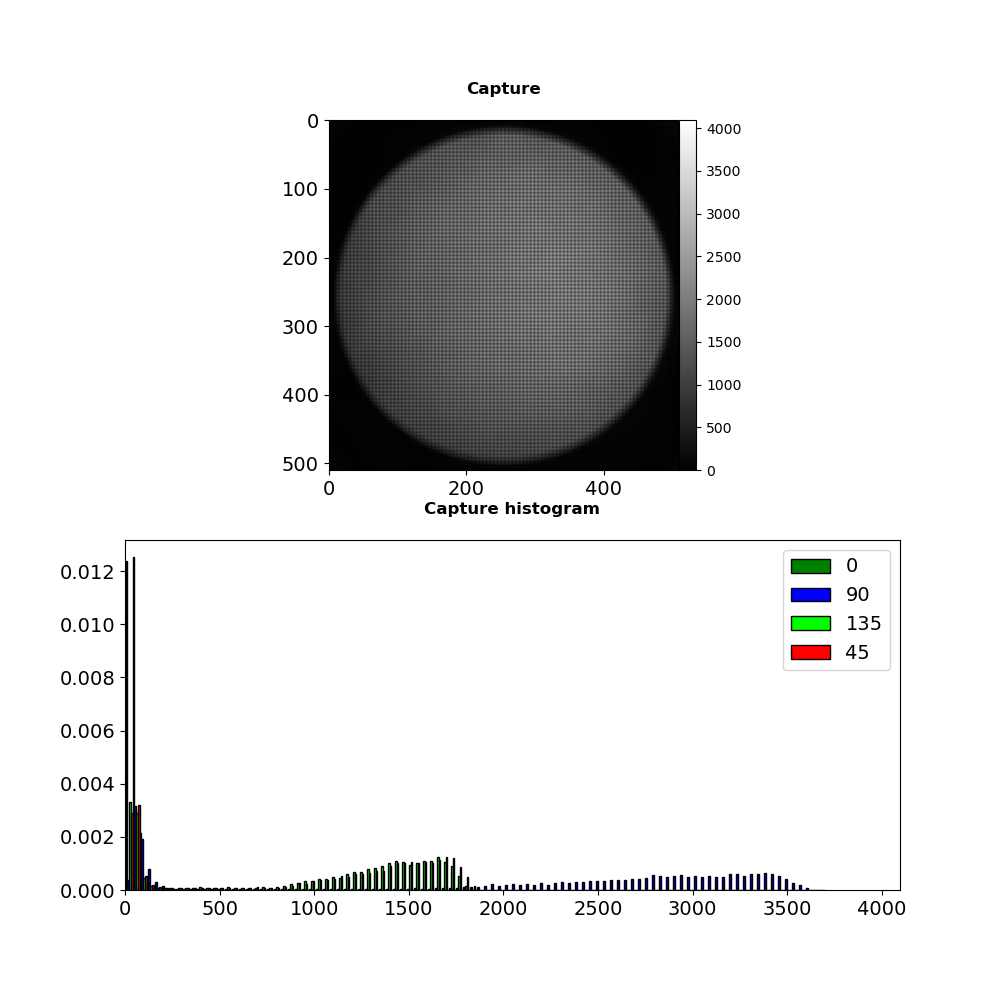

0 - 2022-01-06 15:19:49.588514 - 101933 captured Mono12Packed image 
[[[1269.5 1154.5  245.2]]]


In [6]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (10,10))
ax = ax.flatten()

img, _ = imager.capture_sequence(1,0,0)
img = np.squeeze(np.array(img))

margine = 10
img, roi,x_circ, y_circ, r_circ = get_IS_port_circle_roi(img, margine = margine)

im_0   = img[3::4, 3::4]
im_90  = img[2::4, 2::4]
im_135 = img[3::4, 2::4]
im_45  = img[2::4, 3::4]



colors = ['green', 'blue', 'lime','red']
labels = ['0','90','135','45']

data_for_hist = np.vstack([im_0.ravel(),im_90.ravel(),im_135.ravel(),im_45.ravel()]).T

if PIXELFORMAT == 'Mono12Packed':
    im = ax[0].imshow(img, cmap=plt.get_cmap('gray'), vmin=0, vmax=2**12)

else:
    im = ax[0].imshow(img, cmap=plt.get_cmap('gray'), vmin=0, vmax=2**8)


divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0)
plt.colorbar(im, cax=cax)
ax[0].tick_params(labelsize=14)
ax[0].set_title('Capture\n',
          fontweight ="bold")


# the histogram of the data
if PIXELFORMAT == 'Mono12Packed':
    ax[1].hist(data_for_hist, 100, density = True, 
         histtype ='bar',
         color = colors,
         label = labels,edgecolor='k',rwidth=20)
    # nice reference - https://medium.com/@arseniytyurin/how-to-make-your-histogram-shine-69e432be39ca



    ax[1].set_xlim([0,2**12])
else:
    ax[1].hist(data_for_hist, 100, density = True, 
         histtype ='bar',
         color = colors,
         label = labels,edgecolor='k')

    ax[1].set_xlim([0,2**8])

ax[1].legend(prop ={'size': 14})

ax[1].set_title('Capture histogram\n',
          fontweight ="bold")

ax[1].tick_params(labelsize=14)


In [5]:
# croped_img, roi,_,_,_ = get_IS_port_circle_roi(img)
# croped_img_zoom, roi,_,_,_ = get_IS_port_circle_roi(img, margine = -60)
# clear_img = clear_circle_edges(croped_img)


# REAL TIME STREAMING

In [8]:
num_images = 1
break_sets = 0 #in seconds
break_images = 0 # if == 0: 3 images are taken with no break (for repetition),
                         # then then there is a break_sets.
                         # if break_sets == break_images,
                         # there is no repetition.
            
raw_images, metadata = imager.capture_sequence(num_images, break_sets,break_images)

0 - 2022-01-06 15:22:15.025686 - 101933 captured Mono12Packed image 


In [43]:
# REAL_TIME CAPTURE
font = cv2.FONT_HERSHEY_SIMPLEX
frame_cnt = 0

title = 'Real time stream'
cv2.namedWindow(title, cv2.WINDOW_NORMAL)

while(True):
    
#     start = time.time()
    raw_images, metadata = imager.capture_sequence(num_images, break_sets,break_images)
#     print("Executing an iteration took {} seconds".format(time.time()-start))
    
    raw_images = np.squeeze(np.array(raw_images))
    if num_images > 1:
        mean_image = np.mean(raw_images,axis=0)

    else:
        mean_image = raw_images
        
    frame_show = mean_image.copy()
    
    cv2.putText(frame_show,'Frame {}'
                .format(int(frame_cnt)),(10,50), font, 2,(255),2,cv2.LINE_AA)
    
    frame_cnt = frame_cnt + 1
    
    if PIXELFORMAT == 'Mono12Packed':
        frame_show = (2**8)*(frame_show/(2**12))
    
    frame_show = frame_show.astype('uint8')
    cv2.imshow(title, frame_show)
    
    key = cv2.waitKey(1) 
    # waitKey(1) will display a frame for 1 ms, after which display will be automatically closed.
    # Since the OS has a minimum time between switching threads, the function will not wait exactly 1 ms, it will 
    # wait at least 1 ms, depending on what else is running on your computer at that time.
    if key==ord('q'):
        break
        
    
 
cv2.destroyAllWindows()   

0 - 2022-01-06 14:43:16.596388 - 101933 captured Mono12Packed image 
0 - 2022-01-06 14:43:17.312161 - 101933 captured Mono12Packed image 
0 - 2022-01-06 14:43:17.979634 - 101933 captured Mono12Packed image 
0 - 2022-01-06 14:43:18.653280 - 101933 captured Mono12Packed image 
0 - 2022-01-06 14:43:19.370232 - 101933 captured Mono12Packed image 
0 - 2022-01-06 14:43:20.071089 - 101933 captured Mono12Packed image 
0 - 2022-01-06 14:43:20.771489 - 101933 captured Mono12Packed image 
0 - 2022-01-06 14:43:21.442337 - 101933 captured Mono12Packed image 
0 - 2022-01-06 14:43:22.115461 - 101933 captured Mono12Packed image 
0 - 2022-01-06 14:43:22.770717 - 101933 captured Mono12Packed image 
0 - 2022-01-06 14:43:23.518412 - 101933 captured Mono12Packed image 
0 - 2022-01-06 14:43:24.204963 - 101933 captured Mono12Packed image 
0 - 2022-01-06 14:43:24.890492 - 101933 captured Mono12Packed image 
0 - 2022-01-06 14:43:25.561798 - 101933 captured Mono12Packed image 
0 - 2022-01-06 14:43:26.228026 - 1

In [10]:
cv2.destroyAllWindows()  

# Save images every 1 min

In [ ]:
XTIMEGAP = 1 # sec

In [9]:

frame_cnt = 0
num_images = 1

experiment = "ASRI1"
directory = f"./{experiment}_{exposure}"
if not os.path.exists(directory):
    os.mkdir(directory)
    
    
while(True):
    
#     start = time.time()
    raw_images, metadata = imager.capture_sequence(num_images, break_sets,break_images)
#     print("Executing an iteration took {} seconds".format(time.time()-start))
    
    raw_images = np.squeeze(np.array(raw_images))
    if num_images > 1:
        mean_image = np.mean(raw_images,axis=0)

    else:
        mean_image = raw_images
    
    info = metadata[-1][1].strftime("%Y_%m_%d_%H%M%S")
    np.save(f'./{directory}/frame_{frame_cnt}_{info}', mean_image)
    
    if PIXELFORMAT == 'Mono12Packed':
        mean_image = (2**8)*(mean_image/(2**12))
    
    frame_show = mean_image.astype('uint8')
    
    cv2.imwrite(f'./{directory}/frame_{frame_cnt}_{info}'+'.png',mean_image)
    
    frame_cnt = frame_cnt + 1

    time.sleep(XTIMEGAP)
    
    k = cv2.waitKey(1) & 0xFF
    # press 'q' to exit
    if k == ord('q'):
        break
        


0 - 2022-01-06 15:22:18.113875 - 101933 captured Mono12Packed image 
0 - 2022-01-06 15:22:19.826259 - 101933 captured Mono12Packed image 
0 - 2022-01-06 15:22:21.553480 - 101933 captured Mono12Packed image 
0 - 2022-01-06 15:22:23.299755 - 101933 captured Mono12Packed image 
0 - 2022-01-06 15:22:25.025657 - 101933 captured Mono12Packed image 
0 - 2022-01-06 15:22:26.775864 - 101933 captured Mono12Packed image 
0 - 2022-01-06 15:22:28.464146 - 101933 captured Mono12Packed image 
0 - 2022-01-06 15:22:30.174637 - 101933 captured Mono12Packed image 
0 - 2022-01-06 15:22:31.914478 - 101933 captured Mono12Packed image 
0 - 2022-01-06 15:22:33.641724 - 101933 captured Mono12Packed image 
0 - 2022-01-06 15:22:35.350716 - 101933 captured Mono12Packed image 
0 - 2022-01-06 15:22:37.083264 - 101933 captured Mono12Packed image 
0 - 2022-01-06 15:22:38.813946 - 101933 captured Mono12Packed image 
0 - 2022-01-06 15:22:40.577013 - 101933 captured Mono12Packed image 
0 - 2022-01-06 15:22:42.358916 - 1

KeyboardInterrupt: 

# Make a video from the above captured frames

In [8]:
directory = 'ASRI1_1000'

from PIL import Image, ImageDraw, ImageFont
import glob

IMG_H , IMG_W = mean_image.shape[0] , mean_image.shape[1]
filename = os.path.join(directory,'video.avi')
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
video = cv2.VideoWriter(
            filename,
            fourcc,    #cv2.VideoWriter_fourcc('X','2','6','4'),
            30,
            (IMG_W, IMG_H)
        )

font = ImageFont.truetype("C:/Windows/Fonts/arialbd.ttf", 40, encoding="unic")
image_names = sorted(glob.glob(directory+'\\*.png'))
image_names = sorted(image_names, key=lambda x: int(x.split('\\')[-1].split('_')[1]))

fcolor=(255,0,0)

for idx, image_name in enumerate(image_names):
    print(idx)
    image_ = cv2.imread(image_name)
    image_ = Image.fromarray(np.uint8(image_))
    draw = ImageDraw.Draw(image_)
    img_text = 'Frame_{}'.format(idx)
    
    draw.text(
        (0, 0),
        img_text,
        fill = fcolor,
        font=font
        )    
    
    image_ = np.array(image_)
    video.write(image_)

video.release()
print('done')

0
1
2
3
4
5
6
7
8
9
done


# Test if the exposure is not too short

online loop - do not run the cell below

<IPython.core.display.Javascript object>


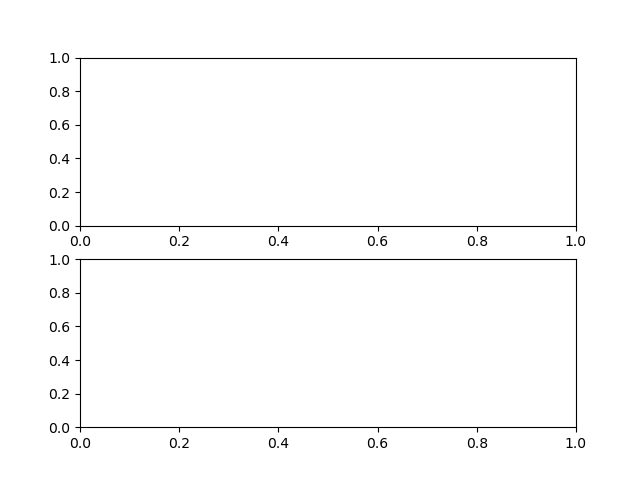

da2_nocover_inside_withblocked_window_ASRI1_2500\frame_0_2022_01_06_145319.npy


NameError: name 'a_img' is not defined

In [9]:
experiment = "ASRI1"
directory = f"./{experiment}_2500"
directory = 'da2_nocover_inside_withblocked_window_ASRI1_2500'

image_names = sorted(glob.glob(directory+'\\*.npy'))
image_names = sorted(image_names, key=lambda x: int(x.split('\\')[-1].split('_')[1]))

fig, ax = plt.subplots(nrows=2, ncols=1)
plt.ion()#interactive on - I need to first draw the figure and can then update the plot in a loop
fig.show()
fig.canvas.draw()

data_plot = []
for idx, image_name in enumerate(image_names):
    print(image_name)
    
    ax[0].clear()
    ax[1].clear()
    
    a = np.load(image_name)
    
    # plot iter:
#     a_img = a[roi[1]:roi[3],roi[0]:roi[2]]

    im_0   = a_img[3::4, 3::4]
    im_90  = a_img[2::4, 2::4]
    im_135 = a_img[3::4, 2::4]
    im_45  = a_img[2::4, 3::4]


    data_for_hist = np.vstack([im_0.ravel(),im_90.ravel(),im_135.ravel(),im_45.ravel()]).T
#     data_plot = im_0/(2**12)
    
    mean_at0_inside_mask = get_mean_responce_of_polarizer(a, polarizer_angle = 0)
    
    data_plot.append(mean_at0_inside_mask)
    ax[0].plot(np.array(data_plot))

    ax[0].tick_params(labelsize=14)
    ax[0].set_title('Capture mean frame {}\n'.format(idx),
              fontweight ="bold")

    plot_hist_polarized(ax= ax[1], data_for_hist=data_for_hist, PIXELFORMAT = PIXELFORMAT)

    fig.tight_layout()

    #--------------------
    fig.canvas.draw()
    time.sleep(0.005)

Without online loop - can take some time to finish. RUN THE CELL BELOW

In [12]:
experiment = "ASRI1"
# directory = f"./{experiment}_2500"

image_names = sorted(glob.glob(directory+'\\*.npy'))
image_names = sorted(image_names, key=lambda x: int(x.split('\\')[-1].split('_')[1]))

data_plot = []
for idx, image_name in enumerate(image_names):

    a = np.load(image_name)
    
    # -- labels = ['0','90','135','45']
    mean_at0_inside_mask = get_mean_responce_of_polarizer(a, polarizer_angle = 0)
    mean_at90_inside_mask = get_mean_responce_of_polarizer(a, polarizer_angle = 90)
    mean_at45_inside_mask = get_mean_responce_of_polarizer(a, polarizer_angle = 45)
    mean_at135_inside_mask = get_mean_responce_of_polarizer(a, polarizer_angle = 135)
    
    k = [mean_at0_inside_mask, mean_at90_inside_mask, mean_at135_inside_mask, mean_at45_inside_mask]
    data_plot.append(k)
    



[[[1268.5 1158.5  240.9]]]
1268 1158 241
mean at polarizer 0 inside circle mask is 2904.715211323764
[[[1268.5 1158.5  240.9]]]
1268 1158 241
mean at polarizer 0 inside circle mask is 56.069790628115655
[[[1268.5 1158.5  240.9]]]
1268 1158 241
mean at polarizer 0 inside circle mask is 1427.6575615591667
[[[1268.5 1158.5  240.9]]]
1268 1158 241
mean at polarizer 0 inside circle mask is 1473.6760479041916
[[[1269.5 1154.5  243.8]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 2904.112105007292
[[[1269.5 1154.5  243.8]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 56.53716117749927
[[[1269.5 1154.5  243.8]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 1426.4657933042213
[[[1269.5 1154.5  243.8]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 1472.508491023775
[[[1269.5 1156.5  243.2]]]
1270 1156 243
mean at polarizer 0 inside circle mask is 2913.776505139501
[[[1269.5 1156.5  243.2]]]
1270 1156 243
mean at polarizer 0 inside circle mask is 56.6

[[[1270.5 1154.5  245.3]]]
1270 1154 245
mean at polarizer 0 inside circle mask is 57.227102354637196
[[[1270.5 1154.5  245.3]]]
1270 1154 245
mean at polarizer 0 inside circle mask is 1446.5302491103203
[[[1270.5 1154.5  245.3]]]
1270 1154 245
mean at polarizer 0 inside circle mask is 1493.5698759257477
[[[1270.5 1154.5  245.2]]]
1270 1154 245
mean at polarizer 0 inside circle mask is 2940.801847752863
[[[1270.5 1154.5  245.2]]]
1270 1154 245
mean at polarizer 0 inside circle mask is 57.211436809226335
[[[1270.5 1154.5  245.2]]]
1270 1154 245
mean at polarizer 0 inside circle mask is 1445.2062133307684
[[[1270.5 1154.5  245.2]]]
1270 1154 245
mean at polarizer 0 inside circle mask is 1491.7986919303646
[[[1269.5 1155.5  244.3]]]
1270 1156 244
mean at polarizer 0 inside circle mask is 2935.0574623237726
[[[1269.5 1155.5  244.3]]]
1270 1156 244
mean at polarizer 0 inside circle mask is 56.97972055113526
[[[1269.5 1155.5  244.3]]]
1270 1156 244
mean at polarizer 0 inside circle mask is 1

[[[1270.5 1154.5  244.5]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 1429.7143134400776
[[[1270.5 1154.5  244.5]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 1476.1941775836972
[[[1270.5 1154.5  244.4]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 2941.6059309674283
[[[1270.5 1154.5  244.4]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 57.20654813951229
[[[1270.5 1154.5  244.4]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 1445.4101892285298
[[[1270.5 1154.5  244.4]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 1491.8373605046095
[[[1269.5 1154.5  244.1]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 2965.4358774914926
[[[1269.5 1154.5  244.1]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 57.542213154571066
[[[1269.5 1154.5  244.1]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 1457.04531780689
[[[1269.5 1154.5  244.1]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 15

[[[1268.5 1157.5  242. ]]]
1268 1158 242
mean at polarizer 0 inside circle mask is 1496.998023715415
[[[1269.5 1154.5  244.1]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 2939.165483714147
[[[1269.5 1154.5  244.1]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 57.09579325755368
[[[1269.5 1154.5  244.1]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 1444.0429888403687
[[[1269.5 1154.5  244.1]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 1490.709849587579
[[[1267.5 1157.5  241.6]]]
1268 1158 242
mean at polarizer 0 inside circle mask is 2910.8328387734914
[[[1267.5 1157.5  241.6]]]
1268 1158 242
mean at polarizer 0 inside circle mask is 56.34263105835806
[[[1267.5 1157.5  241.6]]]
1268 1158 242
mean at polarizer 0 inside circle mask is 1431.1178797468353
[[[1267.5 1157.5  241.6]]]
1268 1158 242
mean at polarizer 0 inside circle mask is 1475.712648221344
[[[1267.5 1157.5  241.4]]]
1268 1158 241
mean at polarizer 0 inside circle mask is 2904.

[[[1271.5 1154.5  245.7]]]
1272 1154 246
mean at polarizer 0 inside circle mask is 2922.387870105062
[[[1271.5 1154.5  245.7]]]
1272 1154 246
mean at polarizer 0 inside circle mask is 56.97472338801984
[[[1271.5 1154.5  245.7]]]
1272 1154 246
mean at polarizer 0 inside circle mask is 1436.5662846227317
[[[1271.5 1154.5  245.7]]]
1272 1154 246
mean at polarizer 0 inside circle mask is 1482.226092765795
[[[1269.5 1154.5  244.1]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 2910.448517258143
[[[1269.5 1154.5  244.1]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 56.65695132614398
[[[1269.5 1154.5  244.1]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 1429.9873847646772
[[[1269.5 1154.5  244.1]]]
1270 1154 244
mean at polarizer 0 inside circle mask is 1475.619311014071
[[[1268.5 1157.5  242.1]]]
1268 1158 242
mean at polarizer 0 inside circle mask is 2898.707418397626
[[[1268.5 1157.5  242.1]]]
1268 1158 242
mean at polarizer 0 inside circle mask is 56.065

Plot intensity as a function of time index. It is a normalized plot and it works on all polarizer filters.

<IPython.core.display.Javascript object>


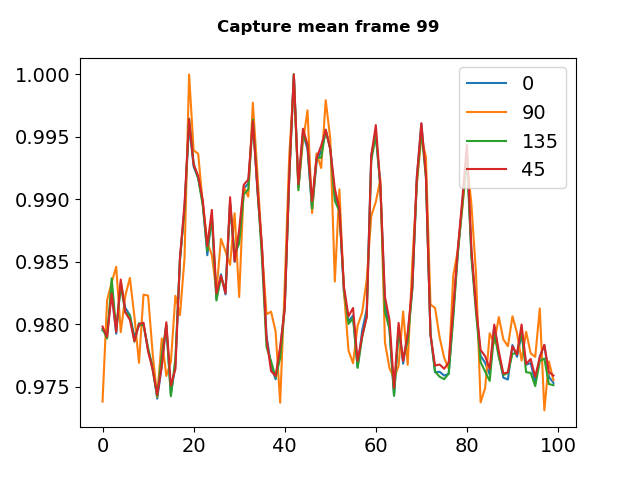

Text(0.5, 1.0, 'Capture mean frame 99\n')

In [13]:
labels = ['0','90','135','45']


fig, ax = plt.subplots(nrows=1, ncols=1)
a = np.array(data_plot)
a = a/a.max(axis = 0)
ax.plot(a, label = labels)

ax.legend(prop ={'size': 14})

ax.tick_params(labelsize=14)
ax.set_title('Capture mean frame {}\n'.format(idx),
          fontweight ="bold")

Plot intensity as a function of time index. It is a absolut plot and it works only on 0 polarizer filter. Prefer to run this cell.

<IPython.core.display.Javascript object>


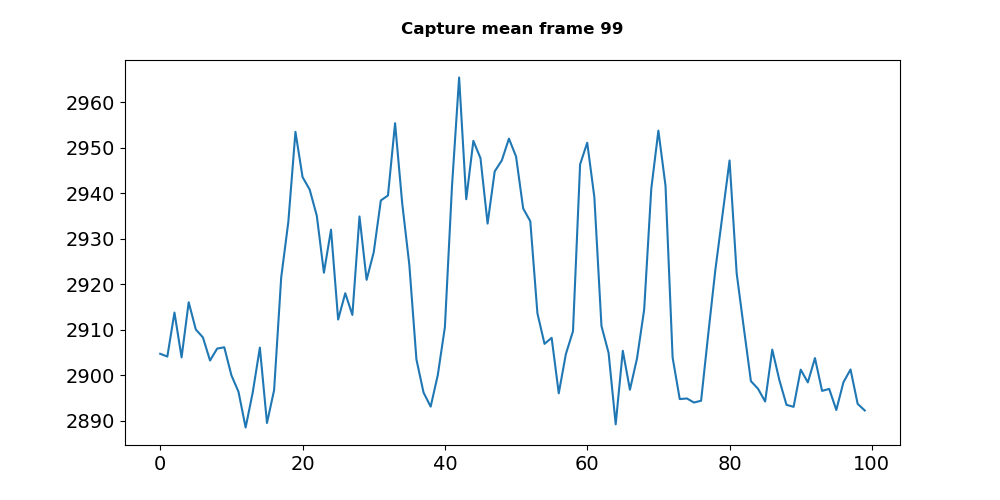

In [17]:
labels = ['0','90','135','45']


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
a = np.array(data_plot)
ax.plot(a[:,0])


ax.tick_params(labelsize=14)
ax.set_title('Capture mean frame {}\n'.format(idx),
          fontweight ="bold")

plt.savefig('intensity variations.png')

In [14]:
std_intensity = np.std(a[:,0])
print(std_intensity)

20.237125953807347


# Analyze only the dark noise

In [19]:
directory_dark = "dark_ASRI1_2500"

image_names = sorted(glob.glob(directory_dark+'\\*.npy'))
image_names = sorted(image_names, key=lambda x: int(x.split('\\')[-1].split('_')[1]))

dark_img = np.load(image_names[0])
Sensor_height, Sensor_width = dark_img.shape

D = len(image_names)# number of images
DATA_MND = np.zeros([Sensor_height, Sensor_width, D])

for index, image_name in enumerate(image_names):
    
    dark_img = np.load(image_name)
    DATA_MND[:,:,index] = dark_img

In [20]:
MEAN = np.mean(DATA_MND, axis=2)
VAR = np.var(DATA_MND, axis=2)

print('min of Mean ', colored(MEAN.min(), 'red'))
print('max of Mean ', colored(MEAN.max(), 'red'),'\n')

print('min of Var ', colored(VAR.min(), 'red'))
print('max of Var ', colored(VAR.max(), 'red'),'\n')

print('mean of Mean ', colored(MEAN.mean(), 'red'))
print('mean of Var ', colored(VAR.mean(), 'red'),'\n')


NameError: name 'colored' is not defined

<IPython.core.display.Javascript object>


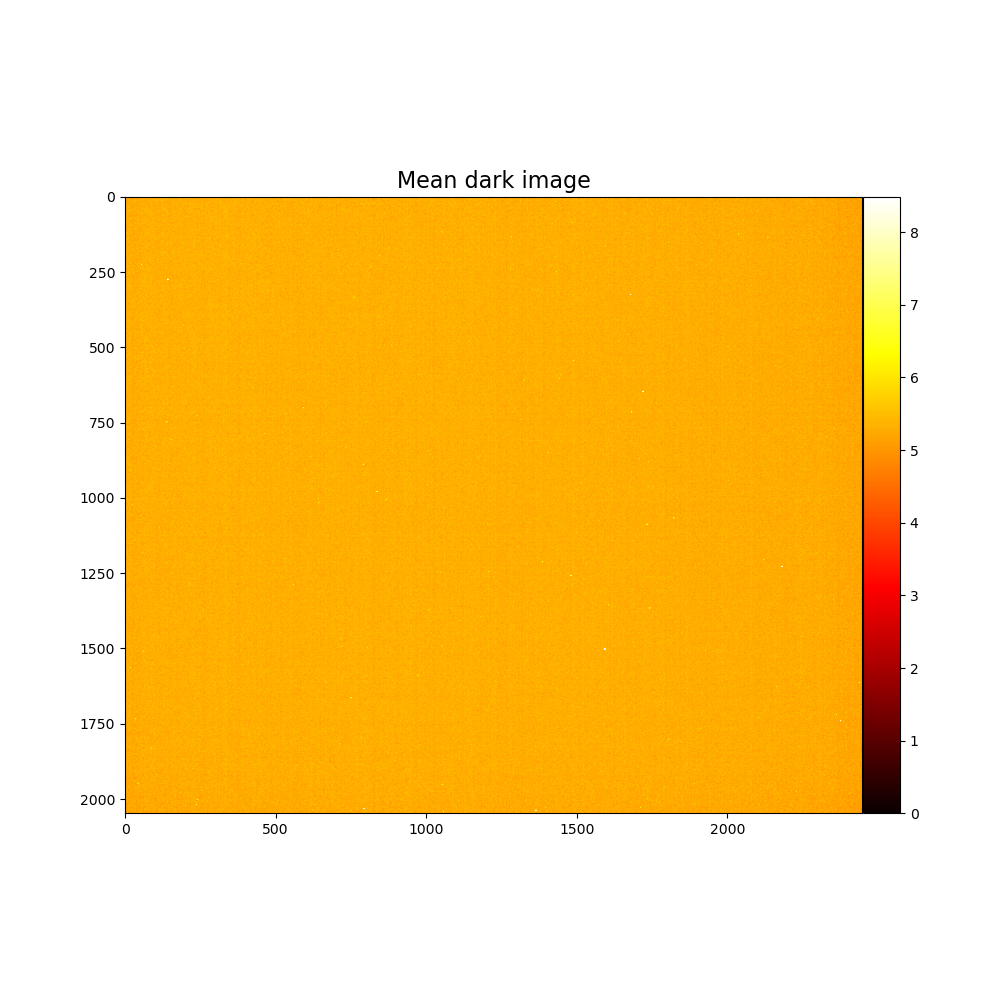

<IPython.core.display.Javascript object>


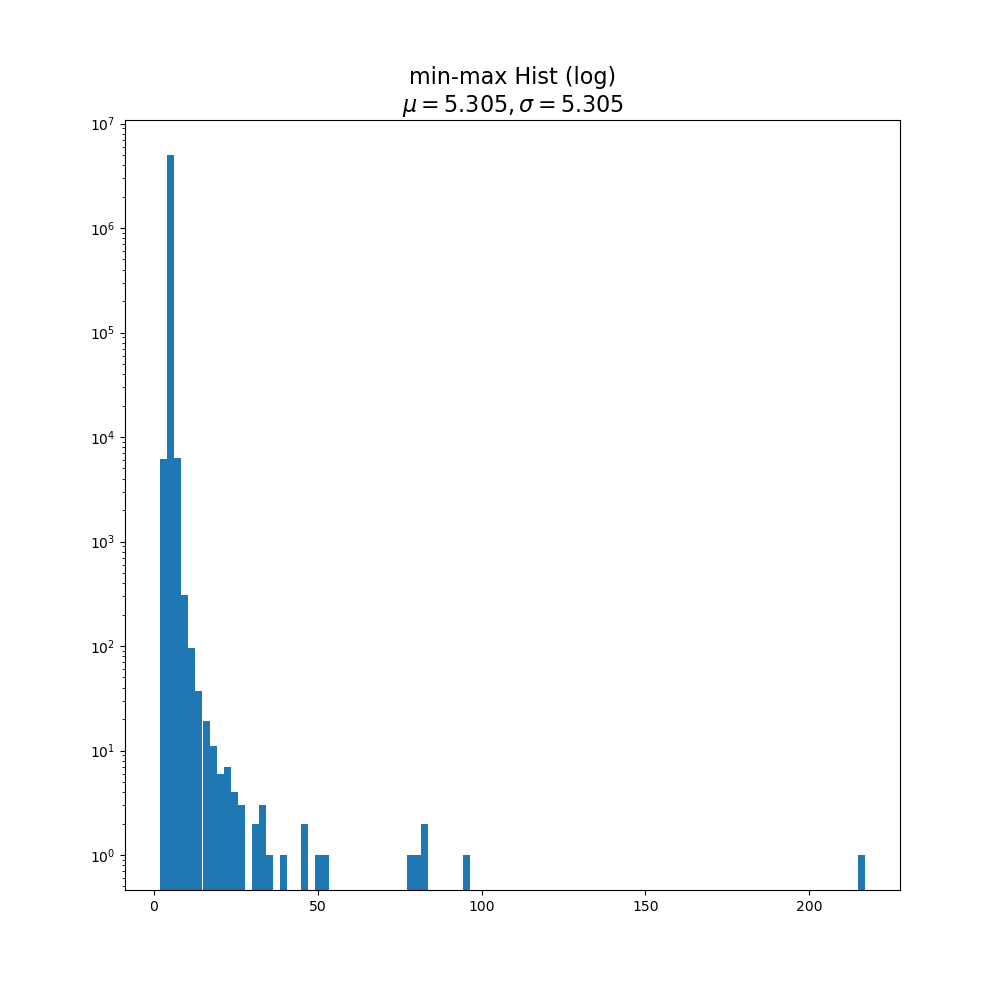

Text(0.5, 1.0, 'min-max Hist (log)\n$\\mu=5.305, \\sigma=5.305$')

In [30]:
fontsize = 16
b = MEAN.copy()

f, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow( b ,cmap='hot', vmin = 0, vmax = 1.6*b.mean())
ax.set_title('Mean dark image', fontsize=fontsize)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
plt.colorbar(im, cax=cax)  

if PIXELFORMAT == 'Mono12Packed':
    M = 2**12
else:
    M = 2**8
        
f, ax = plt.subplots(1, 1, figsize=(10, 10))
# hists:
ax.hist( b.ravel() , 100 , [np.mean([b.min()+1,0]),np.min([b.max()+1,M])] ,log=True)
ax.set_title('min-max Hist (log)\n$\mu={}, \sigma={}$'.format(
    float_round(b.mean()), float_round(b.mean())), fontsize=fontsize)


